In [28]:
import numpy as np
import xarray as xr

In [79]:
import importlib
import functions as md

importlib.reload(md)  # Reload the module

print(md.__file__)

/home/eros/physical-geodesy/code/functions.py


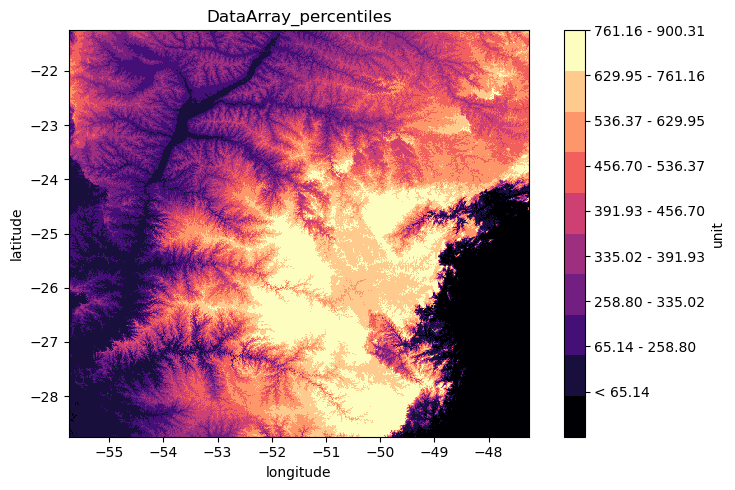

In [37]:
# Importando o MDE

geotiff_path = '../data/MDS_MERIT_SRTM15PLUS_900m_fill.tif'
elevation = md.geotiff_to_dataarray(geotiff_path)
elevation = elevation.rename({'x': 'longitude', 'y': 'latitude'})

md.plot_DataArray_percentiles(
    elevation, 
    x='longitude', 
    y='latitude', 
    label='unit', 
    title='DataArray_percentiles', 
    cmap='magma', 
    num_classes=10
    )

In [ ]:
# Coordenadas geodésicas da estação de cálculo

latP = - (25 + 26/60 + 54.12695/3600) # em graus decimais
longP = - (49 + 13/60 + 51.43717/3600) # m graus decimais
HP = elevation.sel(
    latitude=latP, 
    longitude=longP, 
    method="nearest"
    ).values # HP extraído do MDS


print(f"Latitude: {latP}°")
print(f"Longitude: {longP}°")
print(f"HP: {HP}m")

Latitude: -25.448368597222224°
Longitude: -49.230954769444445°
HP: 920.1061401367188m


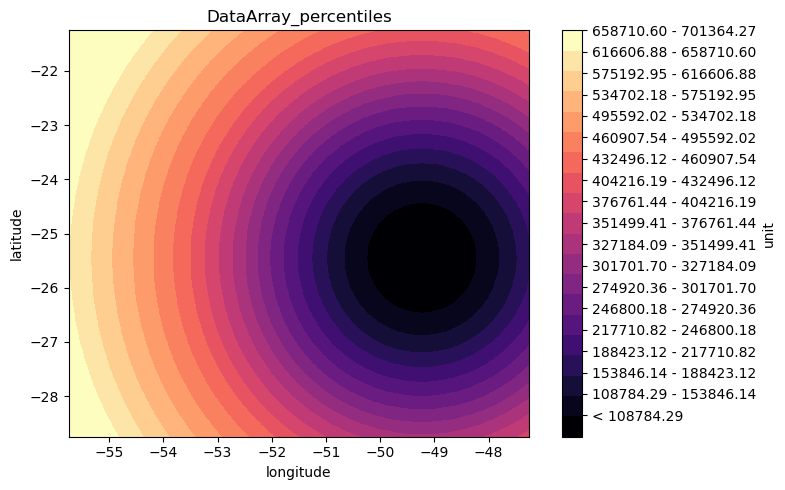

In [62]:
# Criar a grade de coordenadas (equivalente ao broadcast)
lon_grid, lat_grid = np.meshgrid(elevation["longitude"].values, elevation["latitude"].values)

# Calcular deltas em metros (assumindo 1'' = 30m em ambas as direções)
delta_lat = (lat_grid - latP) * 3600 * 30  # em metros
delta_lon = (lon_grid - longP) * 3600 * 30  # em metros

# Distância horizontal r
distance = np.sqrt(delta_lat**2 + delta_lon**2)

unique_x = np.unique(lon_grid[0, :])
unique_y = np.unique(lat_grid[:, 0])

distance = xr.DataArray(
    distance,
    coords={
        "latitude": unique_y,
        "longitude": unique_x
    },
    dims=("latitude", "longitude")
)
distance.name = "distance"

md.plot_DataArray_percentiles(
    distance, 
    x='longitude', 
    y='latitude', 
    label='unit', 
    title='DataArray_percentiles', 
    cmap='magma', 
    num_classes=20
    )

In [63]:
# Calculate resolution in degrees along the longitude and latitude directions
res_longitude = np.mean(np.abs(np.diff(elevation.coords['longitude'].values)))
res_latitude = np.mean(np.abs(np.diff(elevation.coords['latitude'].values)))
res = np.median([res_longitude, res_latitude]) # Resolução em °
res_metros = round((res * 30)*3600) # Resolução em metros
res_metros_2=res_metros**2 # Resolução em metros ao quadrado

print(f"Resolution in degrees: {res}°")
print(f"Resolution in meters: {res_metros}m")
print(f"Resolution in square meters: {res_metros_2} m²")

Resolution in degrees: 0.008333333333333331°
Resolution in meters: 900m
Resolution in square meters: 810000 m²


In [64]:
# Constantes
G = 6.67259e-11   # m3 kg-1 s-2
rho=2670          # kg m-3
print(f"G= {G} kg-1 s-2")
print(f"rho={rho} kg m-3")

G= 6.67259e-11 kg-1 s-2
rho=2670 kg m-3


In [65]:
# Coeficientes em mGal
cte1 = (G * rho / 2) * res_metros_2 * 1e5
cte2 = (3 * G * rho / 8) * res_metros_2 * 1e5

print(f"cte1: {cte1} mGal")
print(f"cte2: {cte2} mGal")

cte1: 7215.405196499999 mGal
cte2: 5411.553897375 mGal


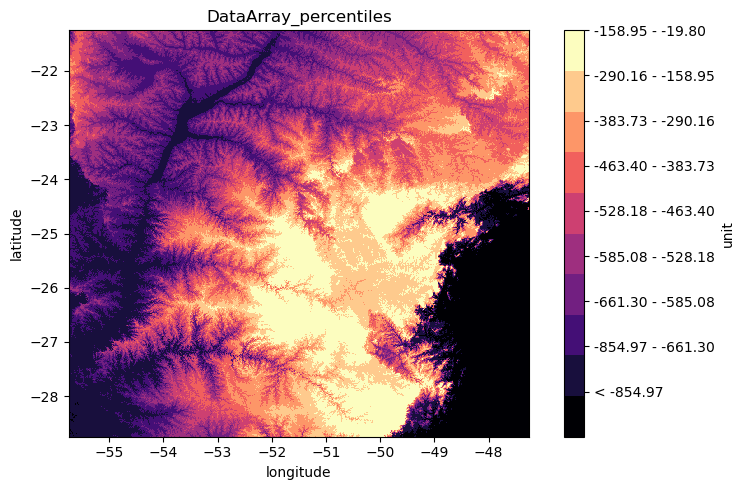

In [66]:
# Diferença de elevação
delta_h = elevation - HP

md.plot_DataArray_percentiles(
    delta_h, 
    x='longitude', 
    y='latitude', 
    label='unit', 
    title='DataArray_percentiles', 
    cmap='magma', 
    num_classes=10
    )

In [73]:
# Constantes
raio_integracao = 100000     # metros



# Aplicação da fórmula com máscara de distância
Ct = xr.where(
    (distance.values <= raio_integracao) & (~xr.ufuncs.isnan(delta_h)),
    cte1 * (delta_h**2) / (distance.values**3) - cte2 * (delta_h**4) / (distance.values**5),
    0.0
)

# Soma total da correção de terreno em mGal
Ct_total = Ct.sum().item()

print(f"Correção de terreno total: {Ct_total:.6f} mGal")


Correção de terreno total: 0.176105 mGal


In [80]:
Ct_total = md.terrain_correction(elevation, 100000, latP, longP, HP=None, G=6.67259e-11, rho=2670)
print(f"Correção de terreno total: {Ct_total:.6f} mGal")

Correção de terreno total: 0.176105 mGal


In [72]:
# Aplica a fórmula da correção de terreno para todos os pixels válidos (sem filtro por distância)

safe_distance = xr.where(distance == 0, 1e-6, distance)

Ct = xr.where(
    ~xr.ufuncs.isnan(delta_h),
    cte1 * (delta_h**2) / (safe_distance.values**3) - cte2 * (delta_h**4) / (safe_distance.values**5),
    0.0
)

# Soma total da correção em mGal
Ct_total = Ct.sum().item()

print(f"Correção de terreno total (sem raio de integração): {Ct_total:.6f} mGal")

Correção de terreno total (sem raio de integração): 0.298856 mGal


In [15]:
gamma_e = 9.7803267715

sin_phi = np.sin(lat_rad)
sin2 = sin_phi ** 2
sin4 = sin_phi ** 4
sin6 = sin_phi ** 6
sin8 = sin_phi ** 8

gamma = (gamma_e * (
        1
        + 0.0052790414 * sin2
        + 0.0000232718 * sin4
        + 0.0000001262 * sin6
        + 0.0000000007 * sin8
    ))*1e5


print(gamma)

978986.7640474108
